In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import minimize

### homework_ex2_01

In [2]:
data1 = pd.read_csv("../data/ex2data1.txt", names=['exam1', 'exam2', 'accepted'])
X1 = np.array(data1.iloc[:, 0:-1])
y1 = np.array(data1.iloc[:, -1]).reshape((-1, 1))
X1_with_bias = np.concatenate([X1, np.ones((X1.shape[0], 1))], axis=1)
theta = np.zeros((X1_with_bias.shape[1], 1))

In [3]:
def logistic_sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression_cost_function(theta, X, y):
    theta = theta.reshape(-1, 1)
    predictions = logistic_sigmoid(np.dot(X, theta))
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

def compute_logistic_gradient(theta, X, y):
    theta = theta.reshape(-1, 1)
    predictions = logistic_sigmoid(np.dot(X, theta))
    gradient = np.dot(X.transpose(), (predictions - y)) / len(y)
    return gradient.flatten()

initial_theta = np.zeros(X1_with_bias.shape[1])

result = minimize(fun=logistic_regression_cost_function, 
                  x0=initial_theta, 
                  args=(X1_with_bias, y1), 
                  jac=compute_logistic_gradient, 
                  method='TNC')

In [4]:
optimal_theta = result.x
print("Optimal Theta:", optimal_theta)
print("Optimal loss:", logistic_regression_cost_function(optimal_theta, X1_with_bias, y1))

optimal_theta = optimal_theta.reshape(-1, 1)
predictions = logistic_sigmoid(np.dot(X1_with_bias, optimal_theta))

predicted_classes = (predictions >= 0.5).astype(int)

accuracy = np.mean(predicted_classes == y1)
print(f"Accuracy: {accuracy * 100:.2f}%")

Optimal Theta: [  0.20623159   0.20147149 -25.16131857]
Optimal loss: 0.20349770158947478
Accuracy: 89.00%


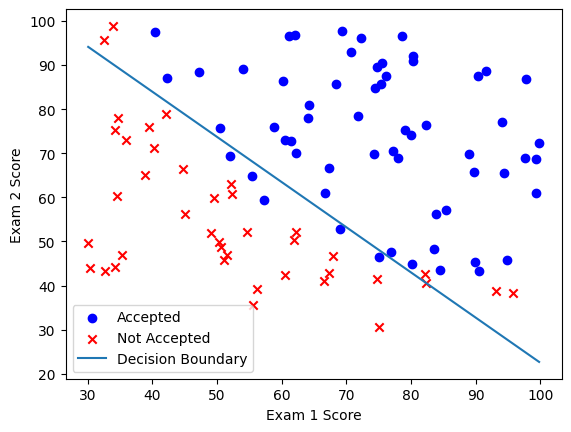

In [5]:
positive = data1[data1['accepted'] == 1]
negative = data1[data1['accepted'] == 0]
plt.scatter(positive['exam1'], positive['exam2'], c='b', marker='o', label='Accepted')
plt.scatter(negative['exam1'], negative['exam2'], c='r', marker='x', label='Not Accepted')

theta_0, theta_1, bias = optimal_theta

plot_x = np.array([min(X1[:, 0]), max(X1[:, 0])])
plot_y = - (bias + theta_0 * plot_x) / theta_1

plt.plot(plot_x, plot_y, label='Decision Boundary')

plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.legend()
plt.show()

### homework_ex2_02

In [6]:
data2 = pd.read_csv("../data/ex2data2.txt", names=['test1', 'test2', 'accepted'])
X2 = np.array(data2.iloc[:, 0:-1])
y2 = np.array(data2.iloc[:, -1]).reshape(-1, 1)

def polynomial_feature_map(X, max_degree=6):
    n_samples, n_features = X.shape
    features = []
    for degree in range(1, max_degree + 1):
        for items in itertools.combinations_with_replacement(range(n_features), degree):
            features.append(np.prod(X[:, items], axis=1))
    features.append(np.ones(n_samples))
    return np.column_stack(features)

X_map = polynomial_feature_map(X2)
theta = np.zeros((X_map.shape[1], 1))

In [7]:
def logistic_sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cross_entropy_loss_regularized(theta, X, y, lambda_reg=0.1):
    theta = theta.reshape(-1, 1)
    predictions = logistic_sigmoid(np.dot(X, theta))
    regularization_loss = (lambda_reg / (2 * len(y))) * np.sum(theta[:-1] ** 2)
    cross_loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cross_loss + regularization_loss

def compute_gradient_regularized(theta, X, y, learning_rate=0.004, lambda_reg=0.1):
    m = len(y)
    n = X.shape[1]
    theta = theta.reshape(-1, 1)
    predictions = logistic_sigmoid(np.dot(X, theta))
    gradients = np.dot(X.transpose(), (predictions - y)) / m
    regularization_term = (lambda_reg / m) * np.concatenate((theta[:-1].flatten(), [0]))
    regularization_term = regularization_term.reshape((n, -1))
    gradients[:-1] += regularization_term[:-1]
    return gradients.flatten()

initial_theta = np.zeros(X_map.shape[1])

result = minimize(fun=cross_entropy_loss_regularized, 
                  x0=initial_theta, 
                  args=(X_map, y2), 
                  jac=compute_gradient_regularized, 
                  method='BFGS')

In [8]:
optimal_theta = result.x
print("Optimal Theta:", optimal_theta)
print("Optimal loss:", cross_entropy_loss_regularized(optimal_theta, X_map, y2))

optimal_theta = optimal_theta.reshape(-1, 1)
predictions = logistic_sigmoid(np.dot(X_map, optimal_theta))

predicted_classes = (predictions >= 0.5).astype(int)

accuracy = np.mean(predicted_classes == y2)
print(f"Accuracy: {accuracy * 100:.2f}%")

Optimal Theta: [ 1.80509477  2.95728751 -4.21414825 -3.3813963  -4.22754697  0.74698222
 -1.08012868 -0.46723329 -0.49721309 -3.26667994  0.52615797 -1.76681777
 -1.20878956 -2.77313878 -0.61887793 -0.4689022   0.62141434 -1.13869849
 -1.20528416 -0.09412244 -2.63058897  0.4469873  -0.738004    0.42300709
 -1.14838836 -0.95609176 -1.15022635  2.75387828]
Optimal loss: 0.39459425925975716
Accuracy: 83.90%


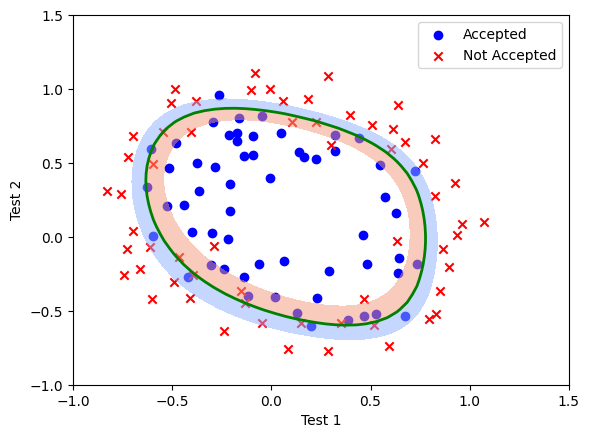

In [9]:
positive = data2[data2['accepted'] == 1]
negative = data2[data2['accepted'] == 0]
plt.scatter(positive['test1'], positive['test2'], c='b', marker='o', label='Accepted')
plt.scatter(negative['test1'], negative['test2'], c='r', marker='x', label='Not Accepted')

u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
U, V = np.meshgrid(u, v)
UV = np.c_[U.ravel(), V.ravel()]

poly_features = polynomial_feature_map(UV)
Z = np.dot(poly_features, optimal_theta)
Z = Z.reshape(U.shape)

plt.contourf(U, V, Z, levels=[-1, 0, 1], cmap=plt.cm.coolwarm, alpha=0.5)
plt.contour(U, V, Z, levels=[0], colors="green", linewidths=2)

plt.xlabel('Test 1')
plt.ylabel('Test 2')
plt.legend()
plt.show()